[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
Nani?! in data
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.23738952 0.93958657]
 [0.15941873 0.00679135 0.2424201  0.91673288]
 ...
 [0.75404546 0.86439547 0.17675049 0.75198726]
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.12256949],
       [0.12224426],
       [0.12903061],
       ...,
       [0.76521772],
       [0.75404546],
       [0.77007934]])

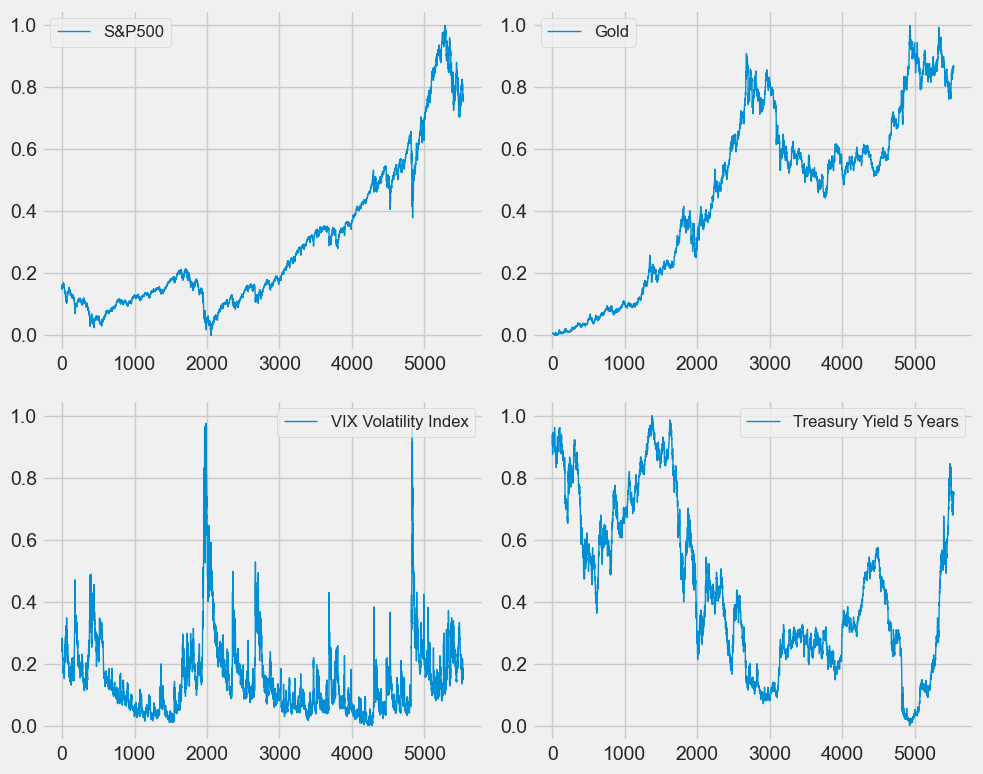

In [2108]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass as dataclass
reload(dataclass)

input_length = 128
output_length = 1
output_steps_ahead = 1
database = dataclass.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [2109]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Stockdataset(Dataset):
    def __init__(self, data, input_length = 128, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
        
size_training = int(len(database.data_norm)*0.8)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = Stockdataset(data_train, input_length, output_length)
test_dataset = Stockdataset(data_test, input_length, output_length)
whole_dataset = Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[1].shape)
print(whole_dataset.__getitem__(0)[0].shape)


(4431, 4)
(1108, 4)
torch.Size([128, 4])
torch.Size([1])
torch.Size([128, 4])


In [2110]:
training_batch_size = 257
batch_size = training_batch_size
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)
whole_dataloader = DataLoader(whole_dataset, batch_size, drop_last = True, shuffle=False)
#whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [2111]:
import torch
class KMeansClusteringLoss(torch.nn.Module):
    def __init__(self):
        super(KMeansClusteringLoss, self).__init__()

    def forward(self, z, mu, sigma_inv):
        length = z.shape[0]
        dim = z.shape[2]
        clusters = mu.shape[0]

        z = z.repeat(1,clusters,1)

        mu = mu.reshape(1,clusters,dim)
        mu = mu.repeat(length,1,1)

        d = torch.sub((mu),  z)
        dl = d.reshape(-1,clusters, 1, dim)
        sigma = torch.matmul((sigma_inv), (torch.transpose((sigma_inv), 2, 1)))
        d2_dS = torch.matmul(dl, sigma)
        dr = d.reshape(length, clusters, dim, 1)
        
        d2 = torch.matmul(d2_dS, dr).reshape(length, clusters,1)
        #d2 = torch.matmul(dl, dr).reshape(length, clusters,1)
        psi = torch.nn.functional.softmax(-d2 + torch.pow(10*torch.ones(length, clusters, 1 ),-10).to(device)).reshape(length, 1, clusters)
        #loss_FCM = torch.sum(torch.mul(psi, d2).min(dim=2)[0])
        
        loss_FCM = torch.sum(torch.mul(psi, torch.matmul(dl, dr).reshape(length, 1, clusters)))
        
        dist = (z-mu).norm(2, dim=2)
        
        loss_KM = dist.min(dim=1)[0].sum()
        
        return loss_FCM
    
class LocalityPreservingLoss(torch.nn.Module):
    def __init__(self):
        super(LocalityPreservingLoss,self).__init__()
    
    def forward(self, x, z):
         
        loss = 0
        return loss
    
        
class QuadraticDiscriminantAnalysis(torch.nn.Module):
    def __init__(self):
        super(QuadraticDiscriminantAnalysis,self).__init__()
    
    def forward(self, z, mu, sigma_inv, pi):
         
        length = z.shape[0]
        dim = z.shape[2]
        clusters = mu.shape[0]
        z = z.repeat(1,clusters,1)
        mu = mu.reshape(1,clusters,dim)
        mu = mu.repeat(length,1,1)
        d = torch.sub((mu),  z)
        dl = d.reshape(-1,clusters, 1, dim)
        sigma = torch.matmul((sigma_inv), (torch.transpose((sigma_inv), 2, 1)))
        d2_dS = torch.matmul(dl, sigma)
        dr = d.reshape(length, clusters, dim, 1)
        d2 = torch.matmul(d2_dS, dr).reshape(length, clusters,1)
        psi = torch.nn.functional.softmax(-d2 + torch.pow(10*torch.ones(length, clusters, 1 ),-5).to(device)).reshape(length, 1, clusters)
        
        #loss = -sum(sum(-torch.log(torch.det(sigma))/2 - d2.reshape(length, clusters)/2 + torch.log(pi.reshape(length, clusters))))
        loss = sum(sum(torch.log(torch.det(sigma))/2 + d2.reshape(length, clusters)/2+ (psi*torch.log(psi)).reshape(length, clusters)))
        return loss
        

In [2112]:
class AttentionDecoder(nn.Module):
  
  def __init__(self, hidden_size, output_size, vocab_size):
    super(AttentionDecoder, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    self.attn = nn.Linear(hidden_size + output_size, 1)
    self.lstm = nn.LSTM(hidden_size + vocab_size, output_size) #if we are using embedding hidden_size should be added with embedding of vocab size
    self.final = nn.Linear(output_size, vocab_size)
  
  def init_hidden(self):
    return (torch.zeros(1, 1, self.output_size),
      torch.zeros(1, 1, self.output_size))
  
  def forward(self, decoder_hidden, encoder_outputs, input):
    
    weights = []
    for i in range(len(encoder_outputs)):
      print(decoder_hidden[0][0].shape)
      print(encoder_outputs[0].shape)
      weights.append(self.attn(torch.cat((decoder_hidden[0][0], 
                                          encoder_outputs[i]), dim = 1)))
    normalized_weights =  torch.nn.functional.softmax(torch.cat(weights, 1), 1)
    
    attn_applied = torch.bmm(normalized_weights.unsqueeze(1),
                             encoder_outputs.view(1, -1, self.hidden_size))
    
    input_lstm = torch.cat((attn_applied[0], input[0]), dim = 1) #if we are using embedding, use embedding of input here instead
    
    output, hidden = self.lstm(input_lstm.unsqueeze(0), decoder_hidden)
    
    output = self.final(output[0])
    
    return output, hidden, normalized_weights

In [2113]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

class EvolvingSystem(nn.Module):
    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads):
        super(EvolvingSystem, self).__init__()
        self.input_size = input_dim
        self.output_size = output_dim
        self.cluster_dim = cluster_dim
        self.num_clusters = num_clusters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        #self.etta = torch.nn.Parameter(data=torch.ones(1), requires_grad=True)
        self.mu = torch.nn.Parameter(data = 3*torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        #self.sigma_inv = torch.nn.Parameter(data=(torch.rand(self.num_clusters,self.cluster_dim, self.cluster_dim)  + 
        #    	torch.diag_embed(2*torch.ones(self.num_clusters,self.cluster_dim))), requires_grad=True)
        self.sigma_inv = torch.nn.Parameter(data=100*torch.rand(self.num_clusters,self.cluster_dim, self.cluster_dim), requires_grad=True)

        #self.sigma = torch.nn.Parameter(torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1)), requires_grad=True)
        #self.sigma_alpha = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)

        #self.fc_con = nn.Linear(input_length, output_length) #output_length
        self.fc_con = nn.Linear(input_length, self.num_clusters) #output_length
        self.fc_recon = nn.Linear(input_length, input_length) #output_length
        self.sm = torch.nn.Softmax(dim = 1)

        self.input_layer_norm = nn.LayerNorm(input_length)
        self.fc_att_emb = nn.Linear(input_length, 2*self.embed_dim) #output_length
        self.msa = nn.MultiheadAttention(self.embed_dim, self.num_heads)
        self.input_layer_att = nn.LayerNorm(input_length)

        self.fc_ant = nn.Linear(input_length, input_length) #self.cluster_dim
        self.relu_ant = nn.ReLU() 
        self.input_layer_ant = nn.LayerNorm(input_length)
        self.fc_latent = nn.Linear(input_length, self.cluster_dim) #self.cluster_dim
        
        #self.evol_drop_layer = nn.Dropout(p=0.5)

    def forward(self, x, u):
        #torch.Size([256, 128, 16]); IxBxH
        #self.x = x.flatten()
        x = x.reshape(batch_size, 1, input_length)
        x = self.input_layer_norm(x)
        
        self.x_emb = self.fc_att_emb(x)
        query, key = self.x_emb.chunk(2, dim=-1)
        value = x
        self.x_att, _ = self.msa(query,key,value)
        self.x_att = self.input_layer_att(self.x_att + value)
        self.x_ant = self.relu_ant(self.fc_ant(self.x_att))
        self.x_ant = self.input_layer_ant(self.x_ant  + self.x_att)
        self.z = self.fc_latent(self.x_ant)
        
        #x_con = self.x_ant
        x_con = self.x_ant
        #self.x_ant = torch.cat((self.x_ant, u.reshape(batch_size,1,1)), dim = 2)

        d = torch.sub((self.mu), self.z)
        dl = d.reshape(batch_size, self.num_clusters, 1, self.cluster_dim)
        
        #TEST OK -> self.mu-self.x_ant[0][0], d[0], dl[0]
        sigma_inv = torch.matmul((self.sigma_inv), torch.transpose((self.sigma_inv), 2, 1))
        #sigma_inv = self.sigma_inv
        
        d2_dS = torch.matmul(dl, sigma_inv)

        dr = d.reshape(batch_size, self.num_clusters, self.cluster_dim, 1)

        #d2 = torch.matmul(d2_dS, dr)
        self.d2 = torch.matmul(d2_dS, dr)
        #d2 = torch.pow(d2, torch.pow(self.etta, 2)
        self.psi = self.sm(-self.d2.reshape(batch_size, self.num_clusters,1))
        #psi = self.evol_drop_layer(psi)
        #TEST OK -> self.sm(-d2).reshape(batch_size,1,self.num_clusters)[0], self.sm(-d2)
        self.psi = self.psi.reshape(batch_size, 1, self.num_clusters)
        #x_con = x_con.repeat(1,self.num_clusters,1)
        y_con = self.fc_con(x_con) #.reshape(batch_size, -1, self.num_clusters) #.reshape(batch_size, output_length, self.num_clusters)
        x_recon = self.fc_recon(x_con).reshape(batch_size, 1, input_length)
        
        #print(torch.sum(psi[0]))
        y = torch.matmul(self.psi , torch.transpose(y_con,-1,-2))
        #self.x_recon = torch.matmul(self.psi, torch.transpose(x_recon,1,0).reshape(input_length,batch_size,self.num_clusters, 1)).reshape(batch_size, 1, input_length)
        
        #final_out = self.fc(out)
        return y, x_recon

In [2114]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.evolve = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads)
        #self.fc = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,hidden_size)

    def forward(self, x, hn, cn):
        out, (hn, cn) = self.lstm(x, (hn, cn))
        out = self.fc(out)
        final_out, x_recon = self.evolve(out, x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, x_recon, hn, cn
    
    '''
    def predict(self, x):
        hn, cn = self.init()
        out = self.fc(out)
        final_out = self.evolve(out, x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn 
    '''
    
    def init(self):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je batch_size tako?
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je treba to dodat tle?
        return h0, c0


Parameter containing:
tensor([-0.0824,  0.0299,  0.0427,  0.0104,  0.0694, -0.0177, -0.0234, -0.0166,
        -0.0460, -0.0815], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0019,  0.0109,  0.0236,  ..., -0.0647, -0.0682,  0.0698],
        [ 0.0179,  0.0802,  0.0668,  ..., -0.0379, -0.0465,  0.0362],
        [ 0.0450, -0.0160,  0.0683,  ...,  0.0832,  0.0811,  0.0247],
        ...,
        [-0.0316,  0.0431,  0.0718,  ...,  0.0623,  0.0172,  0.0034],
        [-0.0362,  0.0036, -0.0377,  ..., -0.0223,  0.0125,  0.0690],
        [ 0.0373,  0.0229, -0.0672,  ..., -0.0248,  0.0209,  0.0422]],
       device='cuda:0', requires_grad=True)


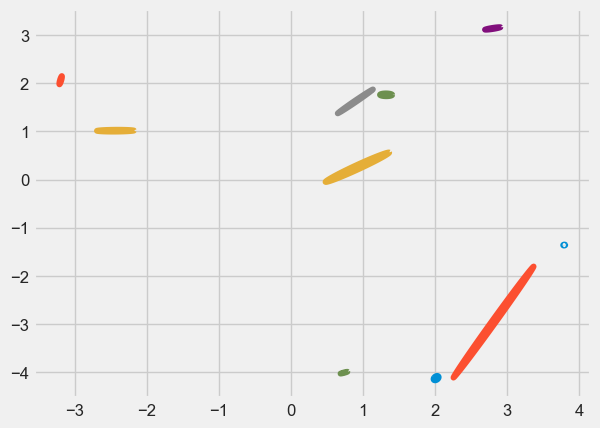

In [2115]:

embed_dim = input_length
num_heads = 32
cluster_dim = 3
num_clusters = 10
input_dim = 4
output_dim = 1
hidden_size = 10
num_layers = 3
model = Lstm_model(input_dim, output_dim, hidden_size, num_layers).to(device)

sigma_inv = model.evolve.sigma_inv
sigma_inv =torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())[:,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()[:,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1]) 
display.display(pl.gcf())   
display.clear_output(wait=True)
time.sleep(0.1)

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)


In [2116]:
def compute_distibution(d2):
    q_num = (1 + d2).pow_(-1)
    q_den = (1 + d2).pow_(-1).sum(2).reshape(-1,1,1)
    q = torch.div(q_num, q_den)
    p_num = torch.div(torch.pow(q, 2), torch.sum(q, 0))
    p_den = torch.sum(torch.div(torch.pow(q, 2), torch.sum(q, 0)),-1).reshape(-1,1,1)
    p = torch.div(p_num, p_den)
    return p

In [2117]:

def train(dataloader, loss_name):
    hn, cn = model.init()
    model.train()
    alpha = 0.5
    loss_sum = 0
    x_ant = np.empty((0,1,cluster_dim))    
     
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, x_recon, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        
        
        loss = torch.zeros(1).to(device)
        if loss_name == "encoder":
            
            loss_recon = loss_fun_recon(x_recon, x[:,:,0].reshape(batch_size, 1, input_length))
            loss = loss + loss_recon
            
        if loss_name == "cluster":
            
            loss_clust = loss_fun_clust(model.evolve.z, model.evolve.mu, model.evolve.sigma_inv)
            loss_DQA = loss_fun_DQA(model.evolve.z, model.evolve.mu, model.evolve.sigma_inv,compute_distibution(model.evolve.d2.reshape(-1,1,num_clusters)))
            #loss_ballance = loss_fun_balance(1/num_clusters*torch.ones(1,num_clusters).to(device), torch.log(torch.sum(model.evolve.psi,0)/batch_size))
            loss_ballance = loss_fun_balance(torch.nn.functional.log_softmax(1/num_clusters*torch.ones(1,num_clusters).to(device)), torch.sum(model.evolve.psi,0)/batch_size)
            loss_assign = loss_fun_assign(torch.nn.functional.log_softmax(model.evolve.psi, -1), compute_distibution(model.evolve.d2.reshape(-1,1,num_clusters)))
            loss = loss + loss_DQA
            if torch.isnan(loss) == True:           
                print(f"ERROR loss_clust {loss_clust}!")
                
        if loss_name == "output": 
            
            loss_con = loss_fun_con(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
            loss = loss + loss_con
          
        loss_sum = loss_sum + loss.item()  
        if torch.isnan(loss) == True:           
            print("ERROR loss!")
        
        x_ant = np.append(x_ant, model.evolve.z.detach().cpu().numpy(),axis=0)
        hn = hn.detach() #detach hn is not a parameters and does not need to be updated!!!
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch == len(dataloader) -1:    
            if False:  
                display.display(pl.gcf())  
                plt.plot(x_recon[0,:,:].detach().cpu().numpy().reshape(input_length, 1))
                plt.plot(x[0,:,0].detach().cpu().numpy().reshape(input_length, 1))  
                plt.show()  
                display.clear_output(wait=True)
            print(f"Train loss: {loss_sum:>7f}")
    return loss_sum, x_ant


'''
model.evolve.mu.grad
model.evolve.sigma_inv.grad
model.evolve.msa.in_proj_weight.grad
model.evolve.msa.in_proj_bias.grad
model.evolve.msa.out_proj.weight.grad
model.evolve.msa.out_proj.bias.grad
model.evolve.fc_ant.weight.grad
model.evolve.fc_ant.bias.grad
model.evolve.fc_con.weight.grad
model.evolve.fc_con.bias.grad
model.evolve.fc_emb.weight.grad
model.evolve.fc_emb.bias.grad
model.evolve.input_layer_norm.weight.grad
model.evolve.input_layer_norm.bias.grad
model.evolve.ant_norm.weight.grad
model.evolve.ant_norm.bias.grad
'''

In [2118]:
def test(dataloader):
    hn, cn = model.init()
    loss_sum = 0
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, x_recon, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        loss = loss_fun_con(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Test loss: {loss_sum:>7f}")   
    return loss_sum
            

In [2119]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lstm.weight_ih_l0 tensor([[-0.2452, -0.2554, -0.0198,  0.2757],
        [ 0.0090,  0.1505, -0.0753, -0.0334],
        [ 0.0917, -0.2990, -0.2973, -0.2573],
        [ 0.2941, -0.1823, -0.1431, -0.0117],
        [ 0.3068, -0.1229, -0.0485,  0.1920],
        [-0.2159, -0.0837,  0.2716, -0.2612],
        [-0.1033,  0.2090,  0.1868, -0.2789],
        [-0.2865,  0.1529,  0.0015,  0.2464],
        [ 0.0036,  0.3001, -0.1288, -0.2112],
        [-0.0943, -0.2772,  0.2800,  0.2648],
        [-0.2634, -0.0878,  0.2096,  0.1973],
        [ 0.2250,  0.0822, -0.1928, -0.2828],
        [-0.1049, -0.1710,  0.0810, -0.1452],
        [ 0.1287,  0.1843, -0.0961, -0.1132],
        [-0.1522,  0.2955,  0.0729, -0.2922],
        [ 0.1459, -0.2392,  0.2593,  0.2170],
        [ 0.2713, -0.2204, -0.2190, -0.2795],
        [-0.0929,  0.2349,  0.0560,  0.2847],
        [ 0.1068,  0.2215,  0.2707,  0.0910],
        [ 0.2731, -0.0443, -0.2434, -0.1935],
        [ 0.1159,  0.0458,  0.1213,  0.2157],
        [ 0.1948

In [2120]:
def compute_GK(z, mu, sigma_inv):
    
    length = z.shape[0]
    dim = z.shape[2]
    clusters = mu.shape[0]

    z = torch.Tensor(z).repeat(1,clusters,1).to(device)

    mu = mu.reshape(1,clusters,dim)
    mu = mu.repeat(length,1,1)

    d = torch.sub((mu),  z)
    dl = d.reshape(-1,clusters, 1, dim)
    sigma = torch.matmul((sigma_inv), torch.transpose((sigma_inv), 2, 1))
    d2_dS = torch.matmul(dl, sigma)
    dr = d.reshape(length, clusters, dim, 1)
    
    d2 = torch.matmul(d2_dS, dr).reshape(length, clusters,1)
    #d2 = torch.matmul(dl, dr).reshape(length, clusters,1)
    psi = torch.nn.functional.softmax(-d2,1).reshape(length,clusters,1).repeat(1,1,dim)
    psi_sigma = psi.reshape(length,clusters,dim,1).repeat(1,1,1,dim)
    
    mu_out = torch.zeros(clusters,dim)
    #sigm_out = torch.zeros(clusters,dim,dim)
    for i in range(clusters):
        mu_out[i,:] = torch.div(sum(torch.mul(psi[:,i,:],z[:,i,:])),sum(psi[:,i,:])[0])
        #sigm_out[i,:,:]  = torch.div(sum(torch.mul(psi_sigma[:,i,:,:],torch.matmul(dr,d2_dS)[:,i,:,:])),sum(psi[:,i,:])[0])
    
    return mu_out

In [2121]:

loss_fun_con = nn.MSELoss()
loss_fun_recon = nn.MSELoss()
loss_fun_assign = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction="sum", log_target=True) #vhodi morajo bit logaritmirani
loss_fun_balance = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction="sum", log_target=True) #vhodi morajo bit logaritmirani
loss_fun_clust = KMeansClusteringLoss()
loss_fun_local = LocalityPreservingLoss()
loss_fun_DQA = QuadraticDiscriminantAnalysis()
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture


In [2122]:
def display_clustering(sigma_inv, mu, x):
        #display.display(pl.gcf())   
        display.clear_output(wait=True) 
        sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
        sigma = inv(sigma_inv.detach().cpu().numpy())
        nc_plot = mu.shape[0]
        sigma = sigma[0:nc_plot,0:2,0:2]
        mu = mu.detach().cpu().numpy()
        mu = mu[0:nc_plot,0:2]
        ellipse = compute_ellipse.Ellipse(sigma,mu,1)
        ellipse_points = ellipse.confidence_ellipse()
        ellipse_points = np.einsum('ijk->jik', ellipse_points)
        plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
        plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
        plt.show()  

In [2123]:
best_model = float('inf')
train_iterations = 1000
batch_size = training_batch_size
for i in range(train_iterations):

    for p in model.parameters():
        p.requires_grad = False 
        
    epochs = 3
    display_clustering(model.evolve.sigma_inv, model.evolve.mu, x_ant_train)

    for p in model.parameters():
        p.requires_grad = True 
    for name, param  in model.named_parameters():
        if "evolve.fc_con.weight" == name:
            param.requires_grad = False
        if "evolve.fc_con.bias" == name:
            param.requires_grad = False
        if "evolve.mu" == name:
            param.requires_grad = False
        if "evolve.sigma_inv" == name:
            param.requires_grad = False
            
    loss_name = "encoder"
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
           
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_encoder, _ = train(train_dataloader,loss_name)
    

    for p in model.parameters():
        p.requires_grad = False 
    for name, param  in model.named_parameters():
        if "evolve.mu" == name:
            param.requires_grad = True
        if "evolve.sigma_inv" == name:
            param.requires_grad = True
    
    '''
    with torch.no_grad():
        gmm = BayesianGaussianMixture(n_components=num_clusters, covariance_type='full', init_params="k-means++").fit(x_ant_train.reshape(-1,cluster_dim))
        #mu = Gaus'sianMixture(x_ant_train, model.evolve.mu, model.evolve.sigma_inv)
        u, s, v  = torch.linalg.svd(torch.from_numpy(gmm.covariances_), full_matrices=True)
        s_sqrt = torch.diag_embed(torch.sqrt(s))
        sigma_inv = torch.linalg.inv(torch.matmul(s_sqrt, v))
        mu = torch.from_numpy(gmm.means_)
        for name, param in model.named_parameters():
            if 'evolve.mu' == name:
                param.copy_(mu)
            if 'evolve.sigma_inv' == name:
                param.copy_(sigma_inv)
    '''    
       
    #GMM_clusters = GaussianMixture(num_clusters, sparsity=20)
    epochs = 2
    loss_name = "cluster"
    lr = 1e-2
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
           
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_cluster, x_ant_train = train(train_dataloader,loss_name)
        display_clustering(model.evolve.sigma_inv, model.evolve.mu, x_ant_train)
    
    for p in model.parameters():
        p.requires_grad = False 
    for name, param  in model.named_parameters():
        if "evolve.fc_con.weight" == name:
            param.requires_grad = True
        if "evolve.fc_con.bias" == name:
            param.requires_grad = True
    loss_name = "output"
    
    lr = 1e-3
    epochs = 3
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_output, _ = train(train_dataloader,loss_name)

    loss_test = test(test_dataloader)
    if (best_model > loss_train):
        best_model = loss_train
        torch.save(model.state_dict(), "model_evolve_cluster.pt")
        
    display_clustering(model.evolve.sigma_inv, model.evolve.mu, x_ant_train)
            


LinAlgError: Array must not contain infs or NaNs

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x, hn, cn)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0]
            y = np.repeat(y.detach().cpu().numpy(),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0]
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        return math.sqrt(mean_squared_error(y_arr,pred_arr))



In [ ]:
from torchsummary import summary

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)

#summary(model,[(input_length, 1, input_dim),(num_layers, 1, hidden_size),(num_layers, 1, hidden_size)])

model.load_state_dict(torch.load("model_evolve_cluster.pt"))
model.eval()


Parameter containing:
tensor([-0.0779, -0.0334, -0.0377, -0.0594, -0.0406,  0.0320, -0.0608,  0.0790,
        -0.0172,  0.0095], device='cuda:0')
Parameter containing:
tensor([[-0.0499, -0.0028, -0.0692,  ..., -0.0397, -0.0602, -0.0466],
        [-0.0652,  0.0458, -0.0553,  ...,  0.0571, -0.0055, -0.0457],
        [ 0.0841,  0.0604, -0.0774,  ...,  0.0535, -0.0143, -0.0874],
        ...,
        [-0.0298,  0.0593,  0.0537,  ..., -0.0477,  0.0484,  0.0195],
        [ 0.0709,  0.0410, -0.0211,  ...,  0.0697, -0.0648,  0.0419],
        [ 0.0457, -0.0776, -0.0059,  ...,  0.0002, -0.0389, -0.0871]],
       device='cuda:0')


Lstm_model(
  (lstm): LSTM(4, 10, num_layers=3)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (evolve): EvolvingSystem(
    (fc_con): Linear(in_features=128, out_features=10, bias=True)
    (fc_recon): Linear(in_features=128, out_features=128, bias=True)
    (sm): Softmax(dim=1)
    (input_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc_att_emb): Linear(in_features=128, out_features=256, bias=True)
    (msa): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (input_layer_att): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc_ant): Linear(in_features=128, out_features=128, bias=True)
    (relu_ant): ReLU()
    (input_layer_ant): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc_latent): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [ ]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

In [ ]:
def simulate(dataloader):
    pred_arr = []
    y_arr = []
    x_ant = np.empty((0,1,cluster_dim))
    model.eval()
    with torch.no_grad():
        (hn, cn) = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            #pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)#[0]
            #pred = model.predict(x.reshape(input_length, batch_size, input_dim))[0]
            pred, x_pred, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
            pred = pred.detach().cpu().numpy().reshape(1,-1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy()
            #plt.plot(np.linspace(1,input_length, input_length), x[0,:,0].detach().cpu().numpy())
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),y[0,:].reshape(-1))
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),pred[0,:].reshape(-1))
            #plt.show()
            pred_arr = pred_arr + list(pred.reshape(-1))
            y_arr = y_arr + list(y.reshape(-1))
            x_ant = np.append(x_ant, model.evolve.z.detach().cpu().numpy(),axis=0)
            
    return pred_arr, y_arr, x_ant
    
whole_pred_arr, whole_y_arr, x_ant  = simulate(whole_dataloader)



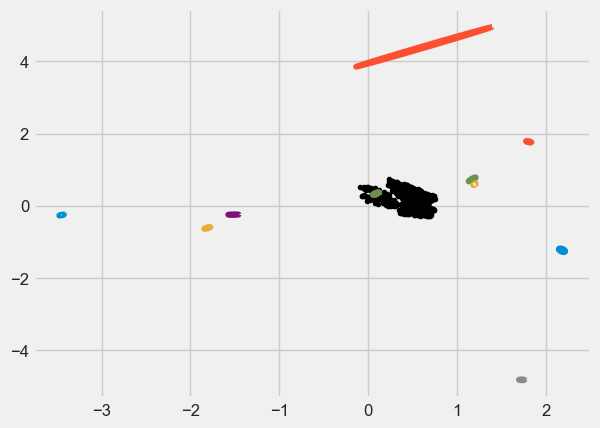

Epoch 0 - encoder
Train loss: 0.023770
Epoch 1 - encoder


KeyboardInterrupt: 

In [ ]:
best_model = float('inf')
train_iterations = 1000
batch_size = training_batch_size
for i in range(train_iterations):

    for p in model.parameters():
        p.requires_grad = False 
        
    epochs = 2
    display_clustering(model.evolve.sigma_inv, model.evolve.mu, x_ant_train)

    for p in model.parameters():
        p.requires_grad = True 
    for name, param  in model.named_parameters():
        if "evolve.fc_con.weight" == name:
            param.requires_grad = False
        if "evolve.fc_con.bias" == name:
            param.requires_grad = False
        if "evolve.mu" == name:
            param.requires_grad = False
        if "evolve.sigma_inv" == name:
            param.requires_grad = False
            
    loss_name = "encoder"
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
           
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_encoder, _ = train(train_dataloader,loss_name)
    

    for p in model.parameters():
        p.requires_grad = False 
    for name, param  in model.named_parameters():
        if "evolve.mu" == name:
            param.requires_grad = True
        if "evolve.sigma_inv" == name:
            param.requires_grad = True
    
    '''
    with torch.no_grad():
        gmm = BayesianGaussianMixture(n_components=num_clusters, covariance_type='full', init_params="k-means++").fit(x_ant_train.reshape(-1,cluster_dim))
        #mu = Gaus'sianMixture(x_ant_train, model.evolve.mu, model.evolve.sigma_inv)
        u, s, v  = torch.linalg.svd(torch.from_numpy(gmm.covariances_), full_matrices=True)
        s_sqrt = torch.diag_embed(torch.sqrt(s))
        sigma_inv = torch.linalg.inv(torch.matmul(s_sqrt, v))
        mu = torch.from_numpy(gmm.means_)
        for name, param in model.named_parameters():
            if 'evolve.mu' == name:
                param.copy_(mu)
            if 'evolve.sigma_inv' == name:
                param.copy_(sigma_inv)
    '''    
       
    #GMM_clusters = GaussianMixture(num_clusters, sparsity=20)
    epochs = 2
    loss_name = "cluster"
    lr = 1e-1
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
           
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_cluster, x_ant_train = train(train_dataloader,loss_name)
        display_clustering(model.evolve.sigma_inv, model.evolve.mu, x_ant_train)
    
    for p in model.parameters():
        p.requires_grad = False 
    for name, param  in model.named_parameters():
        if "evolve.fc_con.weight" == name:
            param.requires_grad = True
        if "evolve.fc_con.bias" == name:
            param.requires_grad = True
    loss_name = "output"
    
    lr = 1e-3
    epochs = 2
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_output, _ = train(train_dataloader,loss_name)

    loss_test = test(test_dataloader)
    if (best_model > loss_train):
        best_model = loss_train
        torch.save(model.state_dict(), "model_evolve_cluster.pt")
        
    display_clustering(model.evolve.sigma_inv, model.evolve.mu, x_ant_train)
            


In [ ]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(figsize = (5, 3))
axes1.plot(whole_y_arr, linewidth=0.5)
axes1.plot(whole_pred_arr, linewidth=0.5)
fig1.savefig("model_evolve_cluster.pdf")


In [ ]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
'''
sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(torch.log(sigma_inv), torch.transpose(torch.log(sigma_inv), 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())
nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = torch.log(model.evolve.mu).detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()
'''   
'''
sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())

nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]

ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.k')
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.m')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()  
'''
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.m')
display_clustering(model.evolve.sigma_inv, model.evolve.mu, x_ant_train)   



In [ ]:
history -g


In [ ]:
'''
%matplotlib inline
import time
import pylab as pl
from IPython import display
#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)
#line1, = axes2.plot(np.zeros(output_length))
#line2, = axes2.plot(np.zeros(output_length))

import matplotlib.pyplot as plt
import time

def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = np.append( pred_arr, pred)
            y_arr = np.append(y_arr, y)

            
            #axes2.cla()  
            #line1.set_ydata(pred_arr)
            #line2.set_ydata(y_arr)
            plt.plot(pred_arr,'b')
            plt.plot(y_arr,'r')
            #fig2.tight_layout()
            #fig2.show()

            display.display(pl.gcf())   
            display.clear_output(wait=True)
            time.sleep(0.1)
            
    return pred_arr, y_arr

batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)
'''